In [1]:
import os,sys
import tensorflow as tf
import numpy as np
import configparser
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization
#from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Conv1D, MaxPooling1D
#from tensorflow.keras.layers import , Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt

In [2]:
class cnnModel(object):
    def __init__(self):
        self.gConfig = self.get_config()        
        self.label_names_dict = self.get_label_dict()
        self.model = []
        self.history = []
        
    def get_config(self, config_file='./config/cnn_config.ini'):
        parser = configparser.ConfigParser()
        parser.read(config_file)
        _conf_ints = [(key, int(value)) for key, value in parser.items('ints')]
        _conf_floats = [(key, float(value)) for key, value in parser.items('floats')]
        _conf_strings = [(key, str(value)) for key, value in parser.items('strings')]
        return dict(_conf_ints + _conf_floats + _conf_strings)    
        
    def build_cnn_model(self):
        model = Sequential()
        model.add(Conv2D(8, kernel_size=(3,3), padding='same', activation='relu', name='conv_1',
                         input_shape=self.train_data.shape[1:]))
        #model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', name='conv_2'))
        model.add(MaxPooling2D(pool_size=(2,2), name='pool_1'))
        model.add(Dropout(0.3, name='drop_1'))
        model.add(BatchNormalization())
        #model.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu', name='conv_3'))
        model.add(Conv2D(16, kernel_size=(3,3), padding='same', activation='relu', name='conv_4'))
        model.add(MaxPooling2D(pool_size=(2,2), name='pool_2'))
        model.add(Dropout(0.3, name='drop_2'))
        model.add(Flatten(name='flatten'))        
        model.add(Dense(8, activation='relu', name="d_1"))
        model.add(Dropout(0.3, name='drop_3'))
        model.add(Dense(self.train_labels.shape[1], activation='softmax', name="outputs"))
        model.summary()
        
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])   
        self.model = model
        return self.model

    def load_train_data(self):
        dataset_path = self.gConfig["dataset_path"]
        images_per_file = self.gConfig["images_per_file"]
        num_channels = self.gConfig["num_channels"]
        im_dim = self.gConfig["im_dim"]                  
        file_names = os.listdir(dataset_path)  
        train_data = []
        train_labels = []
        index = 0
        for file_name in file_names:            
            if file_name[0:len(file_name)-1] == 'data_batch_':
                print('正在處理資料：',file_name)
                with open(dataset_path+file_name,"rb") as fp:                  
                    patch_dict = pickle.load(fp,encoding="bytes")
                    temp_data = patch_dict[b'data']
                    temp_data = temp_data.reshape(images_per_file,num_channels,im_dim,im_dim)
                    temp_data = temp_data.transpose((0,2,3,1))
                    temp_labels = patch_dict[b'labels'] 
                    if index == 0:
                        train_data = temp_data
                        train_labels = temp_labels
                    else:
                        train_data = np.concatenate((train_data, temp_data))
                        train_labels = np.concatenate((train_labels, temp_labels))
                    index += 1
        train_data = train_data.astype("float32") / 255
        train_labels = to_categorical(train_labels)
        self.train_data = train_data
        self.train_labels = train_labels  
        return self.train_data, self.train_labels
        
    def load_test_data(self):
        dataset_path = self.gConfig["test_path"]
        images_per_file = self.gConfig["images_per_file"]
        num_channels = self.gConfig["num_channels"]
        im_dim = self.gConfig["im_dim"]                  
        file_names = os.listdir(dataset_path)  
        test_data = []
        test_labels = []
        index = 0
        for file_name in file_names:            
            if file_name[0:len(file_name)-1] == 'data_batch_':
                print('正在處理資料：',file_name)
                with open(dataset_path+file_name,"rb") as fp:                  
                    patch_dict = pickle.load(fp,encoding="bytes")
                    temp_data = patch_dict[b'data']
                    temp_data = temp_data.reshape(images_per_file,num_channels,im_dim,im_dim)
                    temp_data = temp_data.transpose((0,2,3,1))
                    temp_labels = patch_dict[b'labels'] 
                    if index == 0:
                        test_data = temp_data
                        test_labels = temp_labels
                    else:
                        test_data = np.concatenate((test_data, temp_data))
                        test_labels = np.concatenate((test_labels, temp_labels))
                    index += 1
        test_data = test_data.astype("float32") / 255
        test_labels = to_categorical(test_labels)
        self.test_data = test_data
        self.test_labels = test_labels
        return self.test_data, self.test_labels
        
    def get_label_dict(self):
        file = self.gConfig['dataset_path'] + "batches.meta"
        with open(file, "rb") as fp:
            label_names_dict = pickle.load(fp)["label_names"]
            return label_names_dict
        
    def train_model(self):
        epochs = self.gConfig["epochs"]
        batch_size = self.gConfig["batch_size"]
        self.history = self.model.fit(self.train_data, self.train_labels,
                                      epochs=epochs, batch_size=batch_size,
                                      verbose=1, validation_split=0.2)        
        model_name = self.gConfig["model_name"]
        checkpoint_path = os.path.join(self.gConfig['working_directory'],model_name)
        self.model.save(checkpoint_path)
        print("save model ",model_name)
        #sys.stdout.flush()    

    def load_pretrain_model(self):
        model_name = self.gConfig["model_name"]
        checkpoint_path = os.path.j`oin(self.gConfig['working_directory'],model_name)
        model = load_model(checkpoint_path)
        model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
        self.model = model   
        return self.model
        
    def predict(self, data):   
        result = []
        predictions = self.model.predict(data)    
        for k in predictions:
            index=tf.math.argmax(k).numpy()
            label = self.label_names_dict[index]
            result.append(label)
        return result
    def visual_test_img(self, test_data):
        length = len(test_data)
        plt.figure(figsize=(10,1))
        for i in range(0,length):
            plt.subplot(1,length, (i+1))
            plt.imshow(test_data[i])
            plt.axis("off")
        plt.show()
    
    def visual_train_status(self):
        plt.figure(figsize=(12,3))
        loss = self.history.history["loss"]
        val_loss = self.history.history["val_loss"]
        epochs = range(1, len(loss)+1)  
        plt.subplot(1,2,1)
        plt.plot(epochs, loss, "b--", label="Training Loss")
        plt.plot(epochs, val_loss, "r--", label="Validation Loss")
        plt.title("Training and Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        
        # 顯示訓練和驗證準確度
        acc = self.history.history["accuracy"]
        val_acc = self.history.history["val_accuracy"]
        epochs = range(1, len(acc)+1)
        plt.subplot(1,2,2)
        plt.plot(epochs, acc, "b-", label="Training Acc")
        plt.plot(epochs, val_acc, "r--", label="Validation Acc")
        plt.title("Training and Validation Accuracy")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.show()
        


In [3]:
model = cnnModel()
model.load_train_data()
model.build_cnn_model()

正在處理資料： data_batch_1
正在處理資料： data_batch_2
正在處理資料： data_batch_3
正在處理資料： data_batch_4
正在處理資料： data_batch_5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 32, 32, 8)         224       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 16, 16, 8)         0         
_________________________________________________________________
drop_1 (Dropout)             (None, 16, 16, 8)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 8)         32        
_________________________________________________________________
conv_4 (Conv2D)              (None, 16, 16, 16)        1168      
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 8, 8, 16)          0         
_________________

In [4]:
model.train_model()

Train on 40000 samples, validate on 10000 samples
Epoch 1/3
40000/40000 [==============================] - 55s 1ms/sample - loss: 2.2335 - accuracy: 0.1487 - val_loss: 2.2344 - val_accuracy: 0.1874
Epoch 2/3
40000/40000 [==============================] - 48s 1ms/sample - loss: 2.1482 - accuracy: 0.1719 - val_loss: 2.0352 - val_accuracy: 0.2350
Epoch 3/3
40000/40000 [==============================] - 48s 1ms/sample - loss: 2.0510 - accuracy: 0.1988 - val_loss: 1.9458 - val_accuracy: 0.2664
save model  cnn_model.h5


正在處理資料： data_batch_6
['dog', 'ship', 'airplane', 'ship', 'dog', 'dog', 'automobile', 'dog', 'dog']


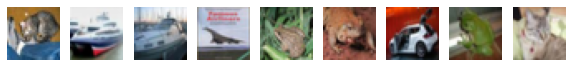

In [5]:
model.load_pretrain_model()
test_data, test_labels = model.load_test_data()
predictions = model.predict(test_data[0:9])
print(predictions)
model.visual_test_img(test_data[0:9])

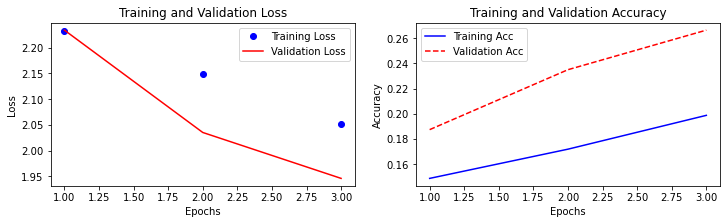

In [6]:
model.visual_train_status()